#Residual Attention Unet 3D for pleural effusion \(with possible lungs injections\)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive, runtime
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
from tensorflow.keras import backend as K
import numpy as np
import sys, os, platform, json, glob, gc, copy, datetime
import ipywidgets as widgets

print('Tensorflow version:',tf.__version__)
print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices("GPU")) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
%matplotlib inline

Tensorflow version: 2.12.0
Python Platform: Linux-5.15.109+-x86_64-with-glibc2.35
Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
GPU is available


In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%load_ext tensorboard

## Setup

In [4]:
PROJECT_FOLDER = "/content/drive/MyDrive/RADLogix"
LUNG_MODEL_FILENAME = "lungs_seg_model.keras"
LUNGS_MODEL_PATH = os.path.join(PROJECT_FOLDER,'ready_models', LUNG_MODEL_FILENAME)
TRAIN_DS_FILE = "train.tfrecords"
VAL_DS_FILE = "val.tfrecords"
TEST_DS_FILE = "test.tfrecords"

# Emptying custom objects
tf.keras.saving.get_custom_objects().clear()

## Define dataset functions

In [19]:
def parse_record(record):
    name_to_features = {
        "shape": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
        "feature": tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)


def decode_record(record, shape):
    feature = tf.io.decode_raw(
        record["feature"],
        out_type="float64",
        little_endian=True,
        fixed_length=None,
        name=None,
    )
    label = tf.io.decode_raw(
        record["label"],
        out_type="int16",
        little_endian=True,
        fixed_length=None,
        name=None,
    )

    rec_shape = tf.io.decode_raw(
        record["shape"],
        out_type="int64",
        little_endian=True,
        fixed_length=None,
        name=None,
    )
    label = tf.cast(tf.reshape(label, rec_shape), tf.float32)
    feature = tf.cast(tf.reshape(feature, rec_shape), tf.float64)
    label.set_shape(shape)
    feature.set_shape(shape)  # important for tf.keras.layers.Normalization.adapt()
    return (feature, label) #x, y

def load_ds(ds_folder='', shape=(64,256,256,1), batch_size=1, use_normalization_layer=True):
    with tf.device("CPU"):
        data = {
            "train_ds": None,
            "val_ds": None,
            "test_ds": None,
            "norm_layer": None,
            #"denorm_layer": None,
        }
        data['train_ds'] = (
            tf.data.TFRecordDataset(
                os.path.join(ds_folder, TRAIN_DS_FILE),
                compression_type="GZIP",
            )
            .map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x: decode_record(x, shape), num_parallel_calls=tf.data.AUTOTUNE)
        )

        if use_normalization_layer:
            norm_ds = data["train_ds"].map(lambda x, y: x)
            data["norm_layer"] = tf.keras.layers.Normalization(axis=None)
            data["norm_layer"].adapt(norm_ds)
            #data["denorm_layer"] = tf.keras.layers.Normalization(axis=None, invert=True)
            #data["denorm_layer"].adapt(norm_ds)
            del norm_ds

        data['train_ds'] = (
            data['train_ds']
            .cache()
            .shuffle(420, reshuffle_each_iteration=False)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
        )

        data["val_ds"] = (
            tf.data.TFRecordDataset(
                os.path.join(ds_folder, VAL_DS_FILE),
                compression_type="GZIP",
            )
            .map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x: decode_record(x, shape), num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .shuffle(80, reshuffle_each_iteration=False)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        data["test_ds"] = (
            tf.data.TFRecordDataset(
                os.path.join(ds_folder, TEST_DS_FILE),
                compression_type="GZIP",
            )
            .map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x: decode_record(x, shape), num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
        )

        return data

## Define losses and metrics

In [6]:
# Helper function to enable loss function to be flexibly used for
# both 2D or 3D image segmentation - source: https://github.com/frankkramer-lab/MIScnn
@tf.keras.saving.register_keras_serializable(package="my_package", name="identify_axis")
def identify_axis(shape):
    # Three dimensional
    if len(shape) == 5:
        return [1, 2, 3]
    # Two dimensional
    elif len(shape) == 4:
        return [1, 2]
    # Exception - Unknown
    else:
        raise ValueError("Metric: Shape of tensor is neither 2D or 3D.")

@tf.keras.saving.register_keras_serializable(package="my_package", name="jacard_coef")
def jacard_coef(y_true, y_pred):
    y_pred = tf.where(y_pred >= 0.5, 1.0, 0.0)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

@tf.keras.saving.register_keras_serializable(package="my_package", name="dice_coef")
def dice_coef(y_true, y_pred):
    smooth = 0.000001
    delta = 0.5
    axis = identify_axis(y_true.get_shape())
    y_pred = tf.where(y_pred >= 0.5, 1.0, 0.0)
    # Calculate true positives (tp), false negatives (fn) and false positives (fp)
    tp = K.sum(y_true * y_pred, axis=axis)
    fn = K.sum(y_true * (1 - y_pred), axis=axis)
    fp = K.sum((1 - y_true) * y_pred, axis=axis)
    dice_class = (tp + smooth) / (tp + delta * fn + (1 - delta) * fp + smooth)
    # Average class scores
    dice = K.mean(dice_class)

    return dice

@tf.keras.saving.register_keras_serializable(package="my_package", name="focal_tversky_loss")
def focal_tversky_loss(y_true, y_pred):
    delta = 0.7
    gamma = 0.75
    smooth = 0.000001
    # Clip values to prevent division by zero error
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    axis = identify_axis(y_true.get_shape())
    # Calculate true positives (tp), false negatives (fn) and false positives (fp)
    tp = K.sum(y_true * y_pred, axis=axis)
    fn = K.sum(y_true * (1 - y_pred), axis=axis)
    fp = K.sum((1 - y_true) * y_pred, axis=axis)
    tversky_class = (tp + smooth) / (tp + delta * fn + (1 - delta) * fp + smooth)
    # Average class scores
    focal_tversky_loss = K.mean(K.pow((1 - tversky_class), gamma))

    return focal_tversky_loss


def symmetric_focal_tversky_loss(delta=0.7, gamma=0.75):
    """This is the implementation for binary segmentation.
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    gamma : float, optional
        focal parameter controls degree of down-weighting of easy examples, by default 0.75
    """

    def loss_function(y_true, y_pred):
        # Clip values to prevent division by zero error
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        axis = identify_axis(y_true.get_shape())
        # Calculate true positives (tp), false negatives (fn) and false positives (fp)
        tp = K.sum(y_true * y_pred, axis=axis)
        fn = K.sum(y_true * (1 - y_pred), axis=axis)
        fp = K.sum((1 - y_true) * y_pred, axis=axis)
        dice_class = (tp + epsilon) / (tp + delta * fn + (1 - delta) * fp + epsilon)

        # calculate losses separately for each class, enhancing both classes
        back_dice = (1 - dice_class[:, 0]) * K.pow(1 - dice_class[:, 0], -gamma)
        fore_dice = (1 - dice_class[:, 1]) * K.pow(1 - dice_class[:, 1], -gamma)

        # Average class scores
        loss = K.mean(tf.stack([back_dice, fore_dice], axis=-1))
        return loss

    return loss_function


def asymmetric_focal_tversky_loss(delta=0.7, gamma=0.75):
    """This is the implementation for binary segmentation.
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    gamma : float, optional
        focal parameter controls degree of down-weighting of easy examples, by default 0.75
    """

    def loss_function(y_true, y_pred):
        # Clip values to prevent division by zero error
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        axis = identify_axis(y_true.get_shape())
        # Calculate true positives (tp), false negatives (fn) and false positives (fp)
        tp = K.sum(y_true * y_pred, axis=axis)
        fn = K.sum(y_true * (1 - y_pred), axis=axis)
        fp = K.sum((1 - y_true) * y_pred, axis=axis)
        dice_class = (tp + epsilon) / (tp + delta * fn + (1 - delta) * fp + epsilon)

        # calculate losses separately for each class, only enhancing foreground class
        back_dice = 1 - dice_class[:, 0]
        fore_dice = (1 - dice_class[:, 1]) * K.pow(1 - dice_class[:, 1], -gamma)

        # Average class scores
        loss = K.mean(tf.stack([back_dice, fore_dice], axis=-1))
        return loss

    return loss_function

## Define model and its blocks

In [1]:
def conv_block(input, filters, activation="None", dropout = 0):
    """
    Convolution block of a UNet encoder
    """
    x = tf.keras.layers.Conv3D(
        filters, (3, 3, 3), padding="same", activation=activation
    )(input)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv3D(
        filters, (3, 3, 3), padding="same", activation=activation
    )(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.activations.relu(x)
    if dropout > 0:
      #x = tf.keras.layers.Dropout(dropout)(x)
      x = tf.keras.layers.SpatialDropout3D(dropout)(x)
    return x

def res_conv_block(input, filters, dropout = 0):
    x = tf.keras.layers.Conv3D(
        filters, (3, 3, 3), padding="same"
    )(input)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv3D(
        filters, (3, 3, 3), padding="same"
    )(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    if dropout > 0:
      #x = tf.keras.layers.Dropout(dropout)(x)
      x = tf.keras.layers.SpatialDropout3D(dropout)(x)

    shortcut = tf.keras.layers.Conv3D(
        filters, (1, 1, 1), padding="same"
    )(input)
    shortcut = tf.keras.layers.BatchNormalization(axis=-1)(shortcut)

    sum = x + shortcut
    sum = tf.keras.activations.relu(sum)

    return sum


def encoder_block(input, filters, dropout=0, concat_layer=None):
    """
    Encoder block of a UNet passes the result from the convolution block
    above to a max pooling layer
    """
    x = input
    x = res_conv_block(x, filters, dropout=dropout)
    if concat_layer is not None:
      #x = tf.keras.layers.concatenate([x, concat_layer])
      x = x * concat_layer
      x = tf.keras.activations.relu(x)
    p = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    return x, p


def attention_gate(g, s, filters): #! MOD
    Wg = tf.keras.layers.Conv3D(filters, (1,1,1), padding="same")(g)
    Wg = tf.keras.layers.BatchNormalization()(Wg)

    Ws = tf.keras.layers.Conv3D(filters, (1,1,1), padding="same")(s)
    Ws = tf.keras.layers.BatchNormalization()(Ws)

    out = tf.keras.activations.relu(Wg + Ws)
    out = tf.keras.layers.Conv3D(filters, (1,1,1), padding="same")(out)
    #out = tf.keras.activations.relu(out)
    out = tf.keras.activations.sigmoid(out) #! mod
    out = out * s
    out = tf.keras.layers.BatchNormalization()(out) #! mod

    return out

def decoder_block(input, filters, concat_layer, dropout=0):
    # Upsample the feature maps
    x = tf.keras.layers.Conv3DTranspose(
        filters, (2, 2, 2), strides=(2, 2, 2), padding="same"
    )(input)
    concat_layer = attention_gate(x, concat_layer, filters)
    x = tf.keras.layers.concatenate(
        [x, concat_layer]
    )  # Concatenation/Skip conncetion with conjugate encoder
    x = res_conv_block(x, filters, dropout=dropout)  # Passed into the convolution block above
    return x

def final_block(input, filters, lungs_mask, dropout=0):
    x = tf.keras.layers.concatenate(
        [input, lungs_mask]
    )  # Concatenation with lungs mask
    x = res_conv_block(x, filters, dropout=dropout)  # Passed into the convolution block above
    return x

def create_model(model_name='my_model', input_shape=(64, 256, 256, 1), min_filters=32, dropout=0, norm_layer=None):
    num_filters = min_filters
    inputs = tf.keras.Input(shape=input_shape)
    lungs_model = tf.keras.models.load_model(LUNGS_MODEL_PATH, compile=False)
    lungs_model.trainable = False
    lungs_mask = lungs_model(inputs)
    lungs_mask = tf.where(lungs_mask >= 0.5, .5, 0.)
    #lungs_mask2 = tf.keras.layers.MaxPooling3D(2)(lungs_mask)
    #lungs_mask3 = tf.keras.layers.MaxPooling3D(2)(lungs_mask2)
    #lungs_mask4 = tf.keras.layers.MaxPooling3D(2)(lungs_mask3)
    x = norm_layer(inputs)
    x = tf.keras.layers.concatenate([x, lungs_mask])
    d1, p1 = encoder_block(x, num_filters, dropout=dropout, concat_layer=None)
    d2, p2 = encoder_block(p1, num_filters*2, dropout=dropout, concat_layer=None)
    d3, p3 = encoder_block(p2, num_filters*4, dropout=dropout, concat_layer=None)
    d4, p4 = encoder_block(p3, num_filters*8, dropout=dropout, concat_layer=None)
    mid = res_conv_block(p4, num_filters*16, dropout=dropout)  # Midsection
    e2 = decoder_block(mid, num_filters*8, d4, dropout=dropout)  # Conjugate of encoder 4
    e3 = decoder_block(e2, num_filters*4, d3, dropout=dropout)  # Conjugate of encoder 3
    e4 = decoder_block(e3, num_filters*2, d2, dropout=dropout)  # Conjugate of encoder 2
    e5 = decoder_block(e4, num_filters, d1, dropout=dropout)  # Conjugate of encoder 1
    outputs = tf.keras.layers.Conv3D(1, (1, 1, 1), activation="sigmoid")(
        e5
    )  # Final Output

    model = tf.keras.Model(inputs=[inputs], outputs=outputs, name=model_name)
    return model

## Model instanciation functions

In [8]:
def compile_model(model, lr=0.001, momentum=0.5, weight_decay=0.001, amsgrad=False, loss=focal_tversky_loss, metrics=[dice_coef, jacard_coef], show_summary=False, plot_model=False, model_path=''):
  optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=amsgrad,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=True,
    ema_momentum=momentum,
    jit_compile=True,
    name='AdamW'
    )

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  if show_summary:
    model.summary()
  if plot_model:
    tf.keras.utils.plot_model(model, to_file=os.path.join(model_path, "logs", f'plot.png'), show_shapes=True, show_dtype=False, show_layer_names=True, expand_nested=False, dpi=70,)
  return model

def run_saved_models(config, ds_data, checkpoints=['min_val_loss', 'max_val_dice']):
    for checkpoint_name in checkpoints:
        checkpoint = f"{config.model_name}${checkpoint_name}"
        loaded_model = get_saved_model(config, checkpoint)
        print(f'\nMODEL {config.model_name} with {checkpoint_name}')
        print('\nEvaluation:')
        loaded_model.evaluate(ds_data["test_ds"], verbose=2)
        print('\nPlots:')
        plot_results(loaded_model, ds_data["test_ds"]) # ds_data['denorm_layer']

def get_model(config, ds_data, model_name=None):
  if model_name is None:
      print(f"CREATING MODEL: {config.model_name}")
      model = create_model(model_name = config.model_name, input_shape=config.shape, min_filters=config.min_filters, dropout=config.dropout, norm_layer=ds_data["norm_layer"])
  else:
    model = get_saved_model(config, model_name)

  model = compile_model(model, lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, amsgrad=config.amsgrad, loss=config.loss, metrics=config.metrics, show_summary=config.show_summary, plot_model=config.plot_model, model_path=config.model_path)
  return model

def get_saved_model(config, checkpoint_name):
    loaded_model = tf.keras.models.load_model(f"{config.model_path}/saved_models/{checkpoint_name}.keras", compile=False)
    loaded_model = compile_model(loaded_model, loss=config.loss, weight_decay=config.weight_decay, amsgrad=config.amsgrad, metrics=config.metrics, show_summary=config.show_summary, plot_model=config.plot_model)
    return loaded_model

def fit_model(config, model, ds_data):
    history = model.fit(
    ds_data["train_ds"], validation_data=ds_data["val_ds"], verbose=2, epochs=config.epochs, callbacks=config.callbacks
    )
    return model, history

def run(config, model_name=None):
    print('LOADING DATASETS...')
    ds_data = load_ds(ds_folder=config.ds_path, shape=config.shape, batch_size=config.batch_size, use_normalization_layer=config.use_normalization_layer)
    model = get_model(config, ds_data, model_name)
    if model_name is not None:
      print('EVALUATING LOADED MODEL...')
      model.evaluate(ds_data["test_ds"], verbose=2)
    print(f"\nTRAINING MODEL: {config.model_name}")
    model, history = fit_model(config, model, ds_data)
    plot_train_report(history)
    print(f"\nEVALUATING MODEL: {config.model_name}")
    model.evaluate(ds_data["test_ds"], verbose=2)
    #print('\nTEST_DS PREDICTIONS')
    #plot_results(model, ds_data["test_ds"].take(12))
    #print('\n')
    #if config.run_checkpoints:
    #  print(f'\nRUNNING SAVED MODELS FOR {config.model_name}:')
    #  run_saved_models(config, ds_data)
    if config.unassign:
      runtime.unassign()

## Define reporting and plotting functions

In [23]:
def plot_train_report(history):
    print('TRAINING REPORT')
    num_epochs = len(history.history['loss'])
    epochs = range(1, num_epochs+1)
    ticks = np.arange(1, num_epochs+1, 10)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    # Plot and label the training and validation loss values
    ax[0].plot(epochs, history.history['loss'], label='Training Loss')
    ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')

    # Add in a title and axes labels
    ax[0].set_title('FOCAL TVERSKY LOSS')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    # Set the tick locations
    ax[0].set_xticks(ticks)

    # Display the plot
    ax[0].legend(loc='best')

    # Plot and label the training and validation dice coef
    ax[1].plot(epochs, history.history['dice_coef'], label='Training Dice')
    ax[1].plot(epochs, history.history['val_dice_coef'], label='Validation Dice')

    # Add in a title and axes labels
    ax[1].set_title('DICE')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Dice coef')

    # Set the tick locations
    ax[1].set_xticks(ticks)

    # Display the plot
    ax[1].legend(loc='best')

    # Plot and label the training and validation jacard coef
    ax[2].plot(epochs, history.history['jacard_coef'], label='Training Jacard')
    ax[2].plot(epochs, history.history['val_jacard_coef'], label='Validation Jacard')

    # Add in a title and axes labels
    ax[2].set_title('JACARD')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Jacard coef')

    # Set the tick locations
    ax[2].set_xticks(ticks)

    # Display the plot
    ax[2].legend(loc='best')

    plt.show()


def overlay_images(x, y, y_pred):
    print("MIDSLICE OVERLAY")
    mid_slice = int(np.round(x.shape[1] / 2))

    x_slice = x[:, mid_slice, :, :, :]
    y_slice = y[:, mid_slice, :, :, :]
    y_pred_slice = y_pred[:, mid_slice, :, :, :]
    dice = dice_coef(y_slice, y_pred_slice)

    x_slice = np.squeeze(x_slice)
    y_slice = np.squeeze(y_slice)
    y_pred_slice = np.squeeze(y_pred_slice)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax[0].imshow(x_slice, cmap="bone", interpolation="none")
    ax[0].imshow(y_slice, cmap="jet", alpha=(0.5 * y_slice))
    ax[1].imshow(x_slice, cmap="bone", interpolation="none")
    ax[1].imshow(y_pred_slice, cmap="jet", alpha=(0.5 * y_pred_slice))

    plt.title(f"Slice: {mid_slice}. Dice: {dice.numpy()}")
    plt.show()


def overlay_slices_slider(images, titles=[]):
    @widgets.interact(axial_slice=(0, images[0].shape[0] - 1))
    def axial_slicer(axial_slice=0):
        num_plots = len(images)
        if len(titles) < num_plots:
            diff = num_plots - len(titles)
            for i in range(diff):
                titles.append("")
        fig, ax = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), squeeze=False)
        ax[0][0].imshow(images[0][axial_slice, :, :], cmap="bone")
        ax[0][0].set_title(titles[0])
        ax[0][0].axis("off")
        for x in range(num_plots - 1):
            ax[0][x + 1].imshow(images[0][axial_slice, :, :], cmap="bone")
            ax[0][x + 1].imshow(
                images[x + 1][axial_slice, :, :],
                cmap="prism",
                alpha=0.5 * images[x + 1][axial_slice],
            )
            ax[0][x + 1].set_title(titles[x + 1])
            ax[0][x + 1].axis("off")
        plt.show()


def plot_3d(
    images,
    labels=["Y True", "Y Pred"],
    colors=["cornflowerblue", "red"],
    alpha=[0.5, 0.5],
    threshold=[0, 0],
    ):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111, projection="3d")
    patches = []

    for idx, image in enumerate(images):
        image = image.transpose(2, 0, 1)
        image = image[:, :, ::-1]

        if idx == 0:
            ax.set_xlim(0, image.shape[0])
            ax.set_ylim(0, image.shape[1])
            ax.set_zlim(0, image.shape[2])

        verts, faces, _, _ = measure.marching_cubes(image, threshold[idx])

        mesh = Poly3DCollection(verts[faces], alpha=alpha[idx])
        face_color = colors[idx]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)
        patches.append(mpatches.Patch(color=colors[idx], label=labels[idx]))
    ax.legend(handles=patches)
    plt.show()


def plot_results(model, dataset): #denorm_layer
  VOXELS_THRESHOLD = 100
  correct_predictions = 0
  total_items = 0
  for x, y in dataset:
      total_items += 1
      y_pred = model.predict(x, verbose=0)
      y_pred = tf.where(y_pred>=0.5, 1.0, 0.0)
      loss = focal_tversky_loss(tf.cast(y, dtype=tf.float32), y_pred)
      dice = dice_coef(tf.cast(y, dtype=tf.float32), y_pred)
      jacard = jacard_coef(tf.cast(y, dtype=tf.float32), y_pred)
      x = tf.squeeze(x).numpy()
      y = tf.squeeze(y).numpy()
      y_pred = tf.squeeze(y_pred).numpy()
      print(f'\nIMAGE {total_items}')
      print(f'FocalTverskyLoss: {loss.numpy()}. Dice: {dice.numpy()}. Jacard: {jacard.numpy()}' )
      if np.max(y) > 0:
          if np.max(y_pred) > 0 and np.count_nonzero(y_pred) > VOXELS_THRESHOLD:
            print(f"CORRECT:  Existing effusion event FOUND. y_pred: {np.count_nonzero(y_pred)}/y_true: {np.count_nonzero(y)} voxels")
            correct_predictions += 1
            plot_3d([y, y_pred])
            overlay_slices_slider(images=[x, y, y_pred], titles=['Initial', 'True', 'Predicted'])
          else:
            print(f"INCORRECT:  Existing effusion event NOT FOUND. y_pred: {np.count_nonzero(y_pred)}/y_true: {np.count_nonzero(y)} voxels")
            plot_3d([y], labels=['Y_TRUE'])
            overlay_slices_slider(images=[x, y, y_pred], titles=['Initial', 'True', 'Predicted'])
      else:
          if np.max(y_pred) > 0 and np.count_nonzero(y_pred) > VOXELS_THRESHOLD:
            print(f"INCORRECT:  Non-existing effusion event FOUND. y_pred: {np.count_nonzero(y_pred)}/y_true: {np.count_nonzero(y)} voxels")
            plot_3d([y_pred], labels=['Y_PRED'], colors=['red'])
            overlay_slices_slider(images=[x, y_pred], titles=['Initial', 'Predicted'])
          else:
            print(f"CORRECT: Non-existing effusion event NOT FOUND. y_pred: {np.count_nonzero(y_pred)}/y_true: {np.count_nonzero(y)} voxels")
            correct_predictions += 1

  print(f'\nTotal correct predictions (with threshold of {VOXELS_THRESHOLD} voxels): {correct_predictions}/{total_items}')

## Model configuration class

In [10]:
class Config():
  def __init__(self, model_name="my_model",
               batch_size=1,
               target_z=64,
               dimension=256,
               ds_folder='ds_1to1_z64_xy256_effusion_aug',
               min_filters=32,
               use_normalization_layer=True,
               dropout=0.2,
               epochs=120,
               lr=0.001,
               momentum=0.5,
               weight_decay=None,
               amsgrad=False,
               loss=focal_tversky_loss,
               metrics=[dice_coef, jacard_coef],
               show_summary=False,
               plot_model=False,
               voxels_threshold=100,
               run_checkpoints=True,
               unassign= False):
    self._model_name = model_name
    self.batch_size = batch_size
    self.target_z = target_z
    self.dimension = dimension
    self.ds_folder = ds_folder
    self.min_filters = min_filters
    self.use_normalization_layer = use_normalization_layer
    self.dropout = dropout
    self.epochs = epochs
    self.lr = lr
    self.momentum = momentum
    self.loss = loss
    self.weight_decay = weight_decay
    self.amsgrad = amsgrad
    self.metrics = metrics
    self.show_summary = show_summary
    self.plot_model = plot_model
    self.voxels_threshold = voxels_threshold
    self.run_checkpoints = run_checkpoints
    self.unassign = unassign
    self.create_folders()
    self.check_dataset()
    self.save_to_JSON()


  def clone(self, new_name):
    clone = copy.deepcopy(self)
    clone._model_name = new_name
    clone.create_folders()
    clone.save_to_JSON()
    return clone

  @property
  def model_name(self):
    return self._model_name

  @model_name.setter
  def model_name(self, v):
    self._model_name = v
    self.create_folders()
    self.save_to_JSON()

  @property
  def shape(self):
    return (self.target_z, self.dimension, self.dimension, 1)

  def get_dict(self):
    data = {
       "model_name": self.model_name,
       "target_z": self.target_z,
       "dimension": self.dimension,
       "shape": self.shape,
       "model_params": {
        "batch_size": self.batch_size,
        "min_filters": self.min_filters,
        "use_normalization_layer": self.use_normalization_layer,
        "dropout": self.dropout,
        "epochs": self.epochs,
        "lr": self.lr,
        "momentum": self.momentum,
        "weight_decay": self.weight_decay,
        "amsgrad": self.amsgrad
       },
        "paths": {
          "ds_folder": self.ds_folder,
          "model_path": self.model_path,
          "logs_path": self.logs_path,
          "saved_models_path": self.saved_models_path,
          "ds_path": self.ds_path,
        },
       "show_summary": self.show_summary,
       "plot_model": self.plot_model,
       "voxels_threshold": self.voxels_threshold,
       "run_checkpoints": self.run_checkpoints
    }
    return data

  def create_folders(self):
        self.model_path = os.path.join(PROJECT_FOLDER, "models", self.model_name)
        self.logs_path = os.path.join(self.model_path, "logs")
        self.tensor_board_logs = os.path.join(self.model_path, "tb_logs")
        self.saved_models_path = os.path.join(self.model_path, "saved_models")
        self.ds_path = os.path.join(PROJECT_FOLDER, 'datasets', self.ds_folder)
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
            os.makedirs(self.logs_path)
            os.makedirs(self.saved_models_path)
            os.makedirs(self.tensor_board_logs)

  def save_to_JSON(self):
        with open(os.path.join(self.model_path, f"{self.model_name}.json"), "w") as file:
            json.dump(self.get_dict(), file)

  def check_dataset(self):
    #print(f"Existing datasets are:")
    #print(os.listdir(os.path.join(PROJECT_FOLDER, 'datasets')))
    if not os.path.exists(self.ds_path):
      print("Provided dataset folder does not exist. Creating folder...")
      os.makedirs(self.ds_path)
      print(f"Dataset folder created: {self.ds_path}")
      print(f"Upload you .tfrecords files.")
    else:
      tf_records = list(map(lambda x: x.split('/')[-1], glob.glob(f"{self.ds_path}/*.tfrecords")))
      if not 'train.tfrecords' in tf_records:
        print('train.tfrecords is missing')
      if not 'val.tfrecords' in tf_records:
        print('val.tfrecords is missing')
      if not 'test.tfrecords' in tf_records:
        print('test.tfrecords is missing')

In [ ]:
#a = Config(model_name='T1')
#b = a.clone('T2')

## Setup callbacks

In [11]:
def set_callbacks(config):
    checkpoint_val_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(config.model_path,'saved_models', f"{config.model_name}$min_val_loss.keras"),
    save_weights_only=False,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )

    checkpoint_val_dice = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(config.model_path, "saved_models", f"{config.model_name}$max_val_dice.keras"),
        save_weights_only=False,
        monitor="val_dice_coef",
        mode="max",
        save_best_only=True,
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=40,
        verbose=0,
        mode='min',
        min_delta=0.0001,
        cooldown=5,
        min_lr=0.0001
    )

    csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(config.model_path, "logs", "log.csv"))

    logdir = os.path.join(config.tensor_board_logs, datetime.datetime.now().strftime("%d%m%Y-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(config.tensor_board_logs, histogram_freq=1)

    callbacks = [
        tf.keras.callbacks.TerminateOnNaN(),
        csv_logger,
        checkpoint_val_loss,
        checkpoint_val_dice,
        tensorboard_callback
        #reduce_lr,
        #tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    ]

    return callbacks

# RUN

In [27]:
CONFIGS = [
    Config(model_name='RAUnet3d__effusion_aug__w_lungs__MD_v2',
           min_filters=24,
           batch_size=3,
           ds_folder='ds_1to1_z64_xy256_effusion_aug',
           lr=0.0005,
           momentum=0.99,
           weight_decay=0.001,
           amsgrad = True,
           dropout=0.2,
           epochs=50,
           run_checkpoints=False,
           unassign=False)
]

for config in CONFIGS:
  config.callbacks = set_callbacks(config)

LOADING DATASETS...
CREATING MODEL: RAUnet3d__effusion_aug__wo_lungs__MD_v1

TRAINING MODEL: RAUnet3d__effusion_aug__wo_lungs__MD_v1
Epoch 1/50
312/312 - 213s - loss: 0.9854 - dice_coef: 0.0246 - jacard_coef: 0.0138 - val_loss: 0.9911 - val_dice_coef: 0.0076 - val_jacard_coef: 0.0041 - 213s/epoch - 681ms/step
Epoch 2/50
312/312 - 118s - loss: 0.9486 - dice_coef: 0.0796 - jacard_coef: 0.0511 - val_loss: 0.9356 - val_dice_coef: 0.0641 - val_jacard_coef: 0.0340 - 118s/epoch - 379ms/step
Epoch 3/50
312/312 - 119s - loss: 0.8913 - dice_coef: 0.1302 - jacard_coef: 0.0886 - val_loss: 0.7936 - val_dice_coef: 0.2518 - val_jacard_coef: 0.2822 - 119s/epoch - 380ms/step
Epoch 4/50
312/312 - 115s - loss: 0.8400 - dice_coef: 0.1947 - jacard_coef: 0.1393 - val_loss: 0.7738 - val_dice_coef: 0.2350 - val_jacard_coef: 0.2887 - 115s/epoch - 367ms/step
Epoch 5/50
312/312 - 119s - loss: 0.8059 - dice_coef: 0.2789 - jacard_coef: 0.2260 - val_loss: 0.7435 - val_dice_coef: 0.3576 - val_jacard_coef: 0.4473 - 1

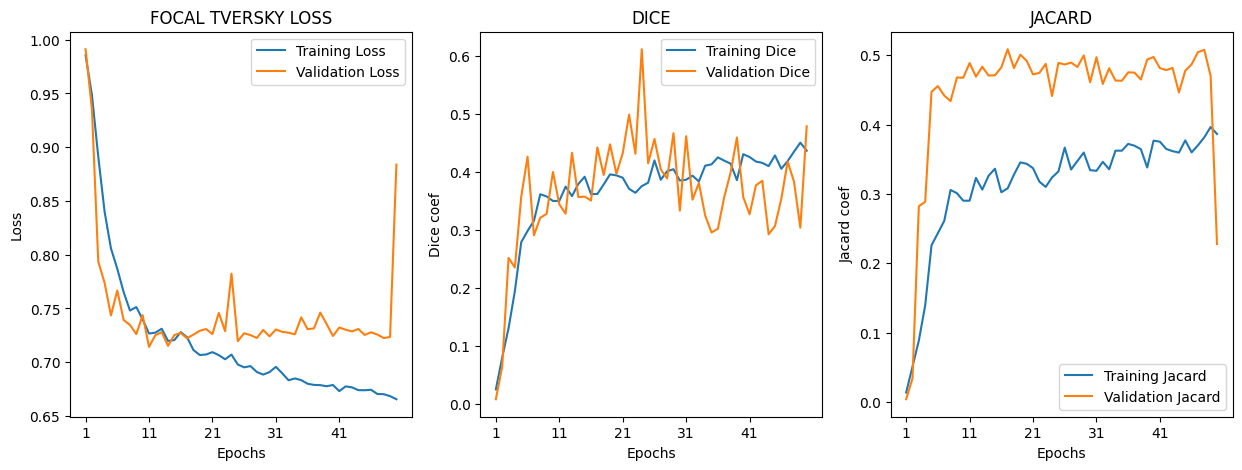


EVALUATING MODEL: RAUnet3d__effusion_aug__wo_lungs__MD_v1
40/40 - 6s - loss: 0.7242 - dice_coef: 0.6379 - jacard_coef: 0.5731 - 6s/epoch - 159ms/step


In [28]:
for config in CONFIGS:
  run(config)

In [ ]:
# to show TensorBoard
for config in CONFIGS:
  logdir = config.tensor_board_logs
  %tensorboard --logdir {logdir}

## Run max_val_dice and min_val_loss models

MIN VAL LOS
40/40 - 8s - loss: 0.7281 - dice_coef: 0.5549 - jacard_coef: 0.4812 - 8s/epoch - 199ms/step

IMAGE 1
FocalTverskyLoss: 0.505192756652832. Dice: 0.6496001482009888. Jacard: 0.4810607433319092
CORRECT:  Existing effusion event FOUND. y_pred: 16785/y_true: 26106 voxels


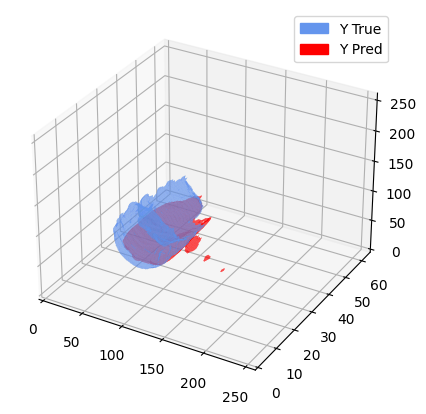

In [ ]:
for config in CONFIGS:
  ds_data = load_ds(ds_folder=config.ds_path, shape=config.shape, batch_size=config.batch_size, use_normalization_layer=config.use_normalization_layer)
  print('MIN VAL LOS')
  model = tf.keras.models.load_model(f'{config.saved_models_path}/{config.model_name}$min_val_loss.keras', compile=False)
  model = compile_model(model, lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, amsgrad=config.amsgrad, loss=config.loss, metrics=config.metrics, show_summary=config.show_summary, plot_model=config.plot_model, model_path=config.model_path)
  model.evaluate(ds_data["test_ds"], verbose=2)
  plot_results(model, ds_data["test_ds"].take(12))
  # if commented out - due to suspicios outliers in the first epochs
  print('\nMAX VAL DICE')
  model = tf.keras.models.load_model(f'{config.saved_models_path}/{config.model_name}$max_val_dice.keras', compile=False)
  model = compile_model(model, lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, amsgrad=config.amsgrad, loss=config.loss, metrics=config.metrics, show_summary=config.show_summary, plot_model=config.plot_model, model_path=config.model_path)
  model.evaluate(ds_data["test_ds"], verbose=2)
  plot_results(model, ds_data["test_ds"].take(12))

## Save to html and pdf

In [ ]:
!apt-get install pandoc
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!jupyter nbconvert /content/drive/MyDrive/RADLogix/model_3dunet/model_res_att_unet_3d.ipynb --to html --output-dir /content/drive/MyDrive/RADLogix/html_reports/ --output RAUnet3d__1

In [ ]:
!jupyter nbconvert /content/drive/MyDrive/RADLogix/model_3dunet/model_res_att_unet_3d.ipynb --to pdf --output-dir /content/drive/MyDrive/RADLogix/html_reports/ --output RAUnet3d__1